# Salary Prediction Model: Random Forest Regression
## Predicting a tech worker's annual compensation based on their job attributes
Sections:
1. Problem Definition and Business Need
2. Data
3. Modeling
4. Model Tuning
5. Evaluation
6. Try It Yourself

# Problem Definition and Business Need

Our goal is to build a machine learning model that can predict the annual compensation of a tech worker based on their location, company, job title, designated market area, years of experience, years at that company, and education.

Our data comes from a Kaggle dataset CSV that uses levels.fyi survey information. 

The model chosen is Sklearn's Random Forest Regression.

Our goal metrics:
* Coefficient of Determination (R^2) > 0.65
* Mean Absolute Error (Average prediction error in USD) < 30,000
* Root Mean Squared Log Error (Relative ratio of predictions vs actual values) < 0.8

In [1]:
# Libraries and methods used
# Please ensure the following libraries are installed in your environment prior to running
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# make visualizations appear inside notebook
%matplotlib inline

# Model and metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# Data
In this section, we import, clean, and visualize our data.

In [2]:
# Import CSV data into pandas dataframe and view
df = pd.read_csv("./data/salary_data.csv")
df

,company,level,title,annualcomp,location,yearsofexperience,yearsatcompany,cityid,dmaid,education
0,Facebook,E9,Product Manager,4980000,"Menlo Park, CA",17.0,0.0,7300,807.0,Master's Degree
1,Microsoft,80,Software Engineering Manager,4950000,"Redmond, WA",24.0,8.0,11521,819.0,NaN
2,Google,L10,Product Manager,4500000,"San Francisco, CA",20.0,14.0,7419,807.0,Master's Degree
3,Facebook,E9,Software Engineer,4490000,"Menlo Park, CA",13.0,9.0,7300,807.0,NaN
4,Snap,L8,Software Engineering Manager,2500000,"Los Angeles, CA",20.0,4.0,7275,803.0,NaN
...,...,...,...,...,...,...,...,...,...,...
62637,Tata Consultancy Services,L1,Software Engineer,10000,"Noida, UP, India",2.0,2.0,42631,0.0,Bachelor's Degree
62638,Xendit,L3,Software Engineer,10000,"Jakarta, JK, Indonesia",1.0,1.0,4010,0.0,Bachelor's Degree
62639,Manhattan Associates,Software Engineer,Software Engineer,10000,"Bangalore, KA, India",4.0,4.0,4058,0.0,Bachelor's Degree
62640,Infosys,L4,Software Engineer,10000,"Pune, MH, India",6.0,4.0,4062,0.0,Bachelor's Degree


In [3]:
# City ID is redundant with "Location" column, so drop the column
df = df.drop("cityid", axis=1)
df.head()

,company,level,title,annualcomp,location,yearsofexperience,yearsatcompany,dmaid,education
0,Facebook,E9,Product Manager,4980000,"Menlo Park, CA",17.0,0.0,807.0,Master's Degree
1,Microsoft,80,Software Engineering Manager,4950000,"Redmond, WA",24.0,8.0,819.0,NaN
2,Google,L10,Product Manager,4500000,"San Francisco, CA",20.0,14.0,807.0,Master's Degree
3,Facebook,E9,Software Engineer,4490000,"Menlo Park, CA",13.0,9.0,807.0,NaN
4,Snap,L8,Software Engineering Manager,2500000,"Los Angeles, CA",20.0,4.0,803.0,NaN


### Categorical feature distribution: How well-distributed are our categorical features?

Total rows: 62,642


Education Value Counts

NaN                  32263
Master's Degree      15395
Bachelor's Degree    12606
PhD                   1704
Some College           355
Highschool             319
Name: education, dtype: int64


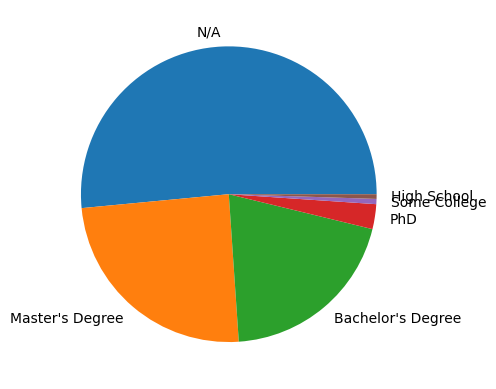

In [4]:
# Education table
print("Education Value Counts\n")

print(df['education'].value_counts(dropna=False))
plt.pie(x=df.education.value_counts(dropna=False),labels=['N/A', 'Master\'s Degree', 'Bachelor\'s Degree', 'PhD', 'Some College', 'High School']);

Unfortunately, over half of the education fields are blank. This could affect our model's accuracy negatively. Bachelor's and Master's degree counts appear evenly split, but there are far fewer High School, Some College, and PhD counts than either. 

A more even distribution would better favor our data. Deleting all of the N/A values would chop our dataset in half though, so we won't do that.

Job Title Value Counts

Software Engineer               41231
Product Manager                  4673
Software Engineering Manager     3569
Data Scientist                   2578
Hardware Engineer                2200
Product Designer                 1516
Technical Program Manager        1381
Solution Architect               1157
Management Consultant             976
Business Analyst                  885
Marketing                         710
Mechanical Engineer               490
Sales                             461
Recruiter                         451
Human Resources                   364
Name: title, dtype: int64


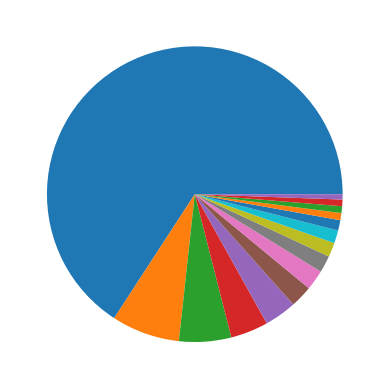

In [5]:
# Job Title table
print("Job Title Value Counts\n")

print(df['title'].value_counts(dropna=False))
plt.pie(x=df.title.value_counts(dropna=False));

Our job titles aren't evenly distributed either, with Software Engineers making a large majority. A way to better evenly distribute the data may be to purchase more survey data. Currently, we will work with the data we have.

Mean annual compensation for each job title


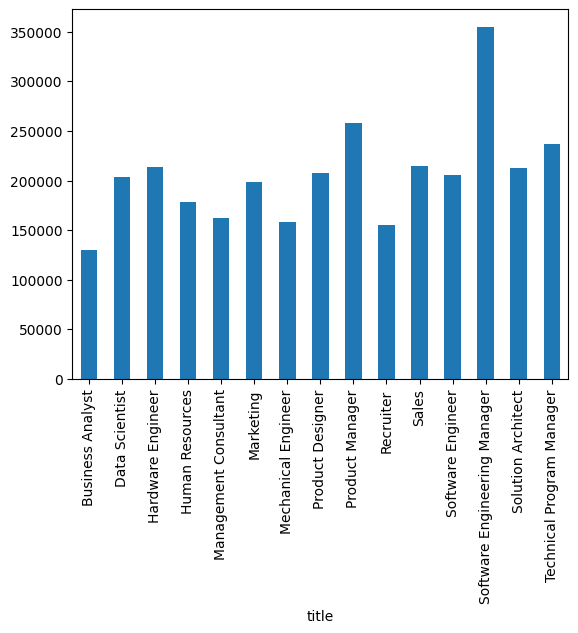

In [6]:
# Mean pay for each title

df_means_by_title = df.groupby('title')['annualcomp'].mean()

print("Mean annual compensation for each job title")
df_means_by_title.plot(kind="bar");

It appears those with "Manager" in the job title have the highest mean pay. Our model may consider this.

Mean annual compensation for each education level


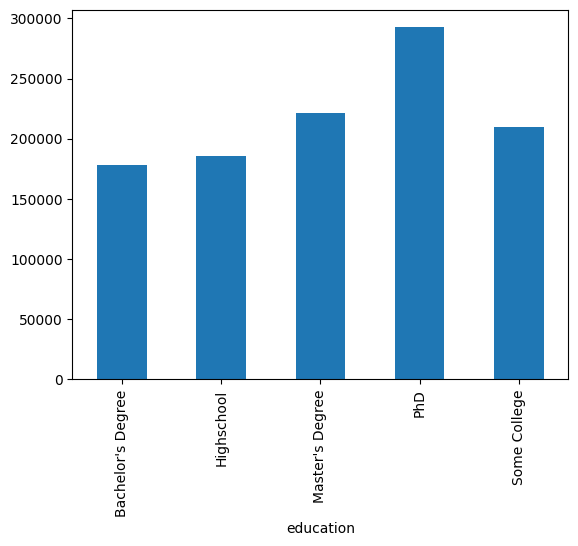

In [7]:
# Mean pay by education
df_means_by_edu = df.groupby('education')['annualcomp'].mean()

print("Mean annual compensation for each education level")
df_means_by_edu.plot(kind="bar");

Most of the data follows the trend of "More years in school = More pay", except Bachelor's Degrees, which are slightly lower than "Some College" and "High School". 

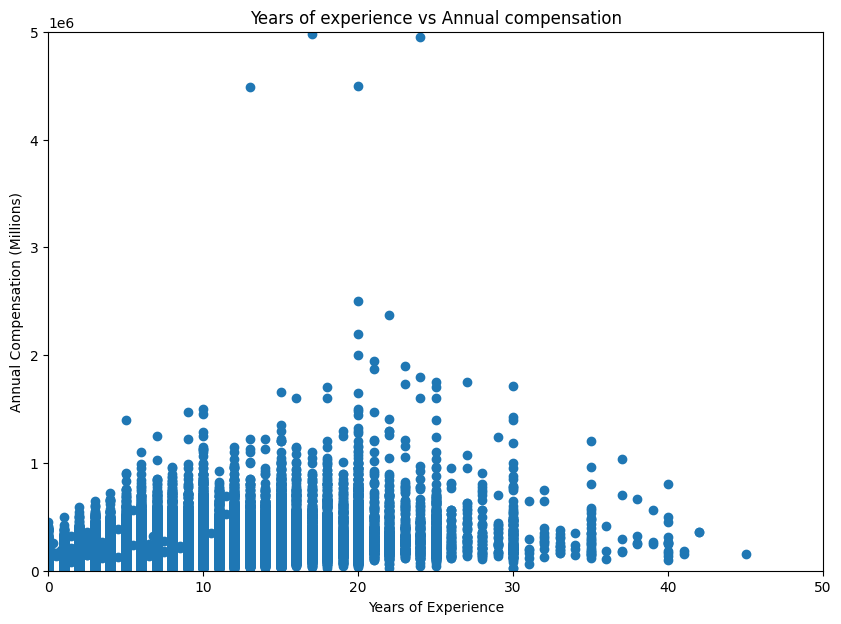

In [8]:
# Scatter plot: years of experience vs annual compensation
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(df["yearsofexperience"], 
                     df["annualcomp"])

ax.set(title="Years of experience vs Annual compensation",
       xlabel="Years of Experience",
       ylabel="Annual Compensation (Millions)",
       ylim=(0, 5000000),
       xlim=(0, 50));

Years of experience doesn't have a strong linear relationship with annual compensation, it seems. It appears to have a normal distribution with a few outliers, those who get paid the most having around the median years of experience.

## Convert and split the data

First, we turn the string data into numeric data by saving them as category types, then changing the categories to nums

Then, we split the data into X (features) and y(target, a.k.a: Annual Compensation).

Then, we split those into three different sets:
The training set is used to train/fit the model
The validation set is used to tune hyperparameters
The test set is used to evaluate our tuned, "final" model

In [9]:
df['company'] = df['company'].astype("category").cat.as_ordered()
df['title'] = df['title'].astype("category").cat.as_ordered()
df['location'] = df['location'].astype("category").cat.as_ordered()
df['education'] = df['education'].astype("category").cat.as_ordered()
df['level'] = df['level'].astype("category").cat.as_ordered()
df['dmaid'] = df['dmaid'].astype("category").cat.as_ordered()

In [10]:
# Turn categorical variables into numbers
for label, content in df.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Indicate if cell had missing val
        df[label+"_is_missing"] = pd.isnull(content)
        # Ensure missing cat is encoded as 0
        df[label] = pd.Categorical(content).codes+1 

In [11]:
# split data into X (features) and y (target)

# shuffle
np.random.seed(11)
df = df.sample(frac=1)

# Split into X and y
X = df.drop("annualcomp", axis=1)
y = df["annualcomp"]

# Model
In this section, we split the data into modeling sets, run the model, and track the baseline metrics

In [12]:
# Split into training, validation, and test

# Create split points in the data
train_split_point = round(0.7*len(df))
valid_split_point = round(train_split_point + (0.15*len(df)))

# Training = 70% of data, Validation = 15% of data, Test = 15% of data
X_train, y_train = X[:train_split_point], y[:train_split_point]
X_valid, y_valid = X[train_split_point:valid_split_point], y[train_split_point:valid_split_point]
X_test, y_test = X[valid_split_point:], y[valid_split_point:]

/var/folders/f0/7k49bmzd7613jyjd90k3fkzm0000gn/T/ipykernel_17460/2182931083.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train, y_train = X[:train_split_point], y[:train_split_point]
/var/folders/f0/7k49bmzd7613jyjd90k3fkzm0000gn/T/ipykernel_17460/2182931083.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_valid, y_valid = X[train_split_point:valid_split_point], y[train_split_point:valid_split_point]
/var/folders/f0/7k49bmzd7613jyjd90k3fkzm0000gn/T/ipykernel_17460/2

In [13]:
# Train the Random Forest Regressor model on the training data
# Implement using a random state of 11 so you can replicate results
model = RandomForestRegressor(n_jobs=-1, random_state=11)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=11)

In [14]:
# Define metrics for each set

# Training set for training model and model fitting
def evaluate_training_metrics(model):
    training_predictions = model.predict(X_train)
    scores = {"Training Mean Absolute Error": mean_absolute_error(y_train, training_predictions),
              "Training Root Mean Squared Log Error": np.sqrt(mean_squared_log_error(y_train, training_predictions)),
              "Training Coefficient of Determination (R^2)": r2_score(y_train, training_predictions)}
    return scores

# Validation set metrics for hyperparameter tuning 
def evaluate_validation_metrics(model):
    validation_predictions = model.predict(X_valid)
    scores = {"Validation Mean Absolute Error": mean_absolute_error(y_valid, validation_predictions),
              "Validation Root Mean Squared Log Error": np.sqrt(mean_squared_log_error(y_valid, validation_predictions)),
              "Validation Coefficient of Determination (R^2)": r2_score(y_valid, validation_predictions)}
    return scores

# Test set metrics for final evaluation of model
def evaluate_test_metrics(model):
    test_predictions = model.predict(X_test)
    scores = {"Test Mean Absolute Error": mean_absolute_error(y_test, test_predictions),
              "Test Root Mean Squared Log Error": np.sqrt(mean_squared_log_error(y_test, test_predictions)),
              "Test Coefficient of Determination (R^2)": r2_score(y_test, test_predictions)}
    return scores


In [15]:
# Metrics for training data (model has already been fit to training data, so these should be good metrics)
evaluate_training_metrics(model)

{'Training Mean Absolute Error': 18968.668721913964,
 'Training Root Mean Squared Log Error': 0.14002302430902064,
 'Training Coefficient of Determination (R^2)': 0.9408496574978172}

### Baseline metrics using validation set
Baseline metrics using data model has not seen before

In [16]:
evaluate_validation_metrics(model)

{'Validation Mean Absolute Error': 47411.08191646569,
 'Validation Root Mean Squared Log Error': 0.31914398881123685,
 'Validation Coefficient of Determination (R^2)': 0.5862516785603646}

Our baseline metrics (prior to model tuning) are:
* Mean Absolute Error (in USD): 47,411.09
* Root Mean Squared Log Error: 0.319
* Coefficient of Determination: 0.586

We can try to improve these metrics with hyperparameter tuning.

# Model Tuning
In this section, we tune the hyperparameters first using RandomizedSearchCV.
Then, we use some of the data from RandomizedSearchCV() to create a more refined grid for an exhaustive grid search using GridSearchCV().

Please note: the hyperparameter searches take some time. You do not need to run those cells if not necessary.

In [17]:
# tune hyperparameters with RandomizedSearchCV
# add commonly used hyperparameters on which model will test
rs_grid = {'n_estimators': [50, 100, 150, 200],
           'max_depth': [None, 10, 30, 40, 50, 60],
           'max_features': ["sqrt", 1, None],
           'min_samples_split': [2,4,6,8,12],
           'min_samples_leaf': [1,2]}

# n_iter=10 to keep time low
rs_model = RandomizedSearchCV(RandomForestRegressor(random_state=11, n_jobs=-1), param_distributions=rs_grid, n_iter=10, cv=2, verbose=True, error_score='raise')

rs_model.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, error_score='raise',
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=11),
                   param_distributions={'max_depth': [None, 10, 30, 40, 50, 60],
                                        'max_features': ['sqrt', 1, None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 4, 6, 8, 12],
                                        'n_estimators': [50, 100, 150, 200]},
                   verbose=True)

In [18]:
# Get best parameters found
rs_model.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': None}

### Metrics using best fit parameters after random search CV

In [19]:
evaluate_validation_metrics(rs_model)

{'Validation Mean Absolute Error': 47065.41225620017,
 'Validation Root Mean Squared Log Error': 0.31713989199503284,
 'Validation Coefficient of Determination (R^2)': 0.5944153610450844}

### Use best parameter data from previous search to perform exhaustive grid search

In [20]:
# Grid Search takes some time. It is not necessary to run.
# GridSearchCV for exhaustive searching
gs_grid = {'n_estimators': [150, 200],
           'min_samples_split': [2, 4],
           'min_samples_leaf': [1,2],
           'max_features': [None],
           'max_depth': [None, 50]}

gs_model = GridSearchCV(RandomForestRegressor(random_state=11, n_jobs=-1), param_grid=gs_grid, cv=2, verbose=True, error_score='raise')

gs_model.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2, error_score='raise',
             estimator=RandomForestRegressor(n_jobs=-1, random_state=11),
             param_grid={'max_depth': [None, 50], 'max_features': [None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [150, 200]},
             verbose=True)

In [21]:
# Get best parameters found
gs_model.best_params_

{'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

### Metrics after grid search's best parameters are found

In [22]:
evaluate_validation_metrics(gs_model)

{'Validation Mean Absolute Error': 46766.51820133491,
 'Validation Root Mean Squared Log Error': 0.3157154038152417,
 'Validation Coefficient of Determination (R^2)': 0.5962544764194473}

# Evaluation

Now we can create the final model using what we know from the previous section, and then evaluate it on never-seen-before test data.

In [23]:
# Create new model based on hyperparameter tuning best-found parameters
# Train tuned model
best_model = RandomForestRegressor(n_jobs=-1, random_state=11, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=None)

best_model.fit(X_train, y_train)

RandomForestRegressor(max_features=None, min_samples_leaf=2, n_estimators=200,
                      n_jobs=-1, random_state=11)

Evaluate the tuned model on our test metrics for final results

In [24]:
evaluate_test_metrics(model)

{'Test Mean Absolute Error': 46733.25665491508,
 'Test Root Mean Squared Log Error': 0.31165105016180406,
 'Test Coefficient of Determination (R^2)': 0.6432329880189673}

Our final metrics:
* Mean Absolute Error (in USD): 46,733.26
* Root Mean Squared Log Error: 0.311
* Coefficient of Determination: 0.643

We were able to slightly improve all metrics from the baseline with hyperparameter tuning.

Our model was able to meet the metrics requirements for the root mean squared log error. The requirement was to be below 0.8 and our model measured at 0.311

The model did not meet the mean absolute error goal requirement. The goal was to be below $30,000, but the model's final metric was $46,733.26.

The model was just unable to meet the Coefficient of Determination requirement, whose goal was to be above 0.65. Our model measured at 0.643.

Some ways we might improve the results in the future:
* Buying more data so that we can remove NaN values and/or have a larger dataset on which to train
* Purchase different data that isn't self-reported
* Perform longer, more exhaustive searches using the hyperparameter tuning tools seen previously

# Try it Yourself

When prompted, type data for yourself or an example tech worker and press enter. The model will run on your data and output an estimated salary.

Please ensure you have run the most recent model with best parameters in the Evaluation Section before trying it yourself. Please follow the prompts in the following cell.

In [25]:
user_company = input("What company do you work for?  ")
user_title = input("What's your job title? (Ex. 'Software Engineer')  ")
user_level = input("Type in a job level if you have one (ex. Google has levels like L1, L2,...)  ")
user_education = input("What is your education level? Please type: 'Bachelor's Degree', 'Master's Degree', 'Some College', 'High School', or 'PhD'  ")
user_location = input("Please enter your location as 'City, State Code' or 'City, Country'. (Ex. 'Sacramento, CA')  ")
user_dmaid = input("Please enter your DMA ID(Ex. New York Designated Market Area would be '501')  ")
user_yoe = int(input("Please enter your years of experience as an integer  "))
user_yac = int(input("Please enter your years at the company as an integer  "))

# Add user data to a new dataframe

data = [[user_company, user_level, user_title, user_location, user_yoe, user_yac, user_dmaid, user_education]]
  
# Create the pandas DataFrame
user_df = pd.DataFrame(data, columns=['company', 'level', 'title', 'location', 'yearsofexperience', 'yearsatcompany', 'dmaid', 'education'])
  
# Create set of features from dataframe
user_df['company'] = df['company'].astype("category").cat.as_ordered()
user_df['title'] = df['title'].astype("category").cat.as_ordered()
user_df['location'] = df['location'].astype("category").cat.as_ordered()
user_df['education'] = df['education'].astype("category").cat.as_ordered()
user_df['level'] = df['level'].astype("category").cat.as_ordered()
user_df['dmaid'] = df['dmaid'].astype("category").cat.as_ordered()

# Turn categorical variables into numbers
for label, content in user_df.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Missing value column
        user_df[label+"_is_missing"] = pd.isnull(content)
        # Ensure missing val is coded as 0 for numeric
        user_df[label] = pd.Categorical(content).codes+1 
        
user_X = user_df

user_prediction = best_model.predict(user_X)

print("\n\n\nAccording to the model, your annual compensation should be: $", user_prediction[0])
print("Thanks for playing!")


What company do you work for?  Google
What's your job title? (Ex. 'Software Engineer')  Software Engineer
Type in a job level if you have one (ex. Google has levels like L1, L2,...)  L2
What is your education level? Please type: 'Bachelor's Degree', 'Master's Degree', 'Some College', 'High School', or 'PhD'  Bachelor's Degree
Please enter your location as 'City, State Code' or 'City, Country'. (Ex. 'Sacramento, CA')  New York, NY
Please enter your DMA ID(Ex. New York Designated Market Area would be '501')  501
Please enter your years of experience as an integer  5
Please enter your years at the company as an integer  2



According to the model, your annual compensation should be: $ 305441.11904761894
Thanks for playing!
